# Kinetic Mechanism Pathway Analyzer

This analyzer is designed to provide a better user experience and improved analyzing capacity (e.g., large mechanisms) compared with Chemkin mechanism analyzer. This analyzer takes reaction ROP file (e.g. Chemkin ckcsv file), builds a reaction network, helps answer

- if the mechanism has certain pathway (from start species to end species)

- what is the biggest flux from/towards a certain species

When using this script, please pay attention to the sections marked with **[user input]** which require user to specify certain input parameters.

In [1]:
from rmgpy.rmg.model import CoreEdgeReactionModel
from rmgpy.chemkin import loadChemkinFile
import os

## [user input] Prepare files

Please add 

- annotated chemkin files (mechanism and species dictionary) and 

- chemkin simulation ckcsv file 

to a folder with name stored in `mech` variable in the next cell.

In [2]:
mechPath = '/home/mjliu/Documents/Models/Tetralin/acetylene/run1'
chemkinPath= os.path.join(mechPath, 'chem_annotated.inp')
dictionaryPath = os.path.join(mechPath, 'species_dictionary.txt')
ckcsvPath= os.path.join(mechPath, 'CKSoln.ckcsv')

model = CoreEdgeReactionModel()
model.core.species, model.core.reactions = loadChemkinFile(chemkinPath,dictionaryPath)

In [3]:
# generate paris for reactions that don't have flux pairs
for rxn in model.core.reactions:
    if not rxn.pairs: rxn.generatePairs()

## Create reaction network

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
from rmgpy.tools.extractInfoFromckcsv import getConcentrationDictFromCKCSV, getROPFromCKCSV, getFluxGraphEdgesDict
from rmgpy.chemkin import getSpeciesIdentifier
from IPython.display import display
import numpy as np
from rmgpy.rmg.pdep import PDepReaction
%matplotlib inline

### step1: prepare a dict for graph edges

In [5]:
firstColDict, spc_mf_dict = getConcentrationDictFromCKCSV(ckcsvPath)
first_col_dict, spc_total_rop_dict, spc_rop_dict = getROPFromCKCSV(ckcsvPath)

graph_edges_dict = getFluxGraphEdgesDict(spc_rop_dict, model.core.reactions)

graph_edges_dict_simple = {}
for pair in graph_edges_dict:
    node1 = getSpeciesIdentifier(pair[0])
    node2 = getSpeciesIdentifier(pair[1])
    graph_edges_dict_simple[(node1, node2)] = graph_edges_dict[pair]

### [user input] step2: pick a time to analyze pathways

Please specify 

- the time point you want to investigate

- the chemkin name of your initial species/reactant

- the reaction temperature in K

- the reaction pressure in Pa if the mechanism includes pressure-dependent reactions

- showIntegratedFlux: True if users want to use time-integrated fluxes (integrated up to the investigated time point) in mole for analysis. Flase if users want to use instantaneous fluxes in mole/cm3/s at the investigated time point for analysis

In [6]:
########## User Input ####################
time_investigated = 1.0/3600 # hour
reactant_name = 'C10H12(1)'
T = 1200 # K
P = 16*101325 # Pa
showIntegratedFlux = True 
##########################################


timepoint_index = (np.abs(firstColDict['Time_(sec)']-time_investigated*3600)).argmin()
timeList = firstColDict['Time_(sec)']
Plist = firstColDict['Pressure_(atm)']
Tlist = firstColDict['Temperature_(k)']
Vlist = firstColDict['Volume_(cm3)']

print "Investigated time point is {0} secs".format(timeList[timepoint_index])
print "At this moment, the reactant's mole fraction is {}.".format(spc_mf_dict[reactant_name][timepoint_index])

# Create moleFraction_dict at the investigated time point
moleFraction_dict = {}
for i, v in spc_mf_dict.items():
    moleFraction_dict.update({i:v[timepoint_index]})

# Create species_identifier_didct for the core species    
species_identifier_dict = {}
for i, s in enumerate(model.core.species):
    species_identifier_dict.update({getSpeciesIdentifier(model.core.species[i]): s})

# find the total consumption of the reactant in mol (positive value means consumption)
reactantConsumption = 0 # 
for t in range(timepoint_index):
    reactantROP0 = spc_total_rop_dict[reactant_name][1][t] # in mole/cm3*s
    reactantROP1 = spc_total_rop_dict[reactant_name][1][t+1] # in mole/cm3*s
    #integrate the flux using a trapezoidal rule
    reactantConsumption += 0.5 * (reactantROP1 * Vlist[t+1] + reactantROP0 * Vlist[t]) * (timeList[t+1] - timeList[t])
reactantConsumption = reactantConsumption * -1.0 # in mole

if showIntegratedFlux:
    print "At this moment, the reactant's total molar consumption is {0:.3E} mole.".format(reactantConsumption)

# create DiGraph for this moment
G = nx.DiGraph()
for pair in graph_edges_dict:
    node1 = getSpeciesIdentifier(pair[0])
    node2 = getSpeciesIdentifier(pair[1])
    e_rawdata = graph_edges_dict[pair]
    total_flux = 0
    for rxn in e_rawdata:
        if showIntegratedFlux:
            for t in range(timepoint_index):
                rxnROP0 = e_rawdata[rxn][t] # in mole/cm3
                rxnROP1 = e_rawdata[rxn][t+1] # in mole/cm3
                #integrate the flux using a trapezoidal rule
                total_flux += 0.5 * (rxnROP1 * Vlist[t+1] + rxnROP0 * Vlist[t]) * (timeList[t+1] - timeList[t]) # in mole
        else:
            total_flux += e_rawdata[rxn][timepoint_index] # in mole/cm3*s
    if total_flux >= 0:
        G.add_edge(node2, node1, {"total_flux":total_flux}) # in G, positive means production of node1
    else: 
        G.add_edge(node1, node2, {"total_flux":-total_flux}) # in G, negative means consumption of node1   

Investigated time point is 1.0 secs
At this moment, the reactant's mole fraction is 1.710172e-09.
At this moment, the reactant's total molar consumption is 8.130E-05 mole.


## [user input] Functionality 1: find most dominant species at the investigated time point

Pleae specify

- dominant_list: If you want to visualize the first top 10 dominant species, specify the list as [0, 9]. If you want to visualize from the 5th most dominant species to the 10th most dominant species, specify the list as [4, 9].


Order 	 Species 	 Mole Frac. 	 MW (g/mol)
0 	 C(8044) 	 0.335172 	 16


--------------------------------------------------------------
1 	 S(15595) 	 0.2722374 	 128


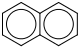

--------------------------------------------------------------
2 	 H2(17) 	 0.1869485 	 2


--------------------------------------------------------------
3 	 S(21309) 	 0.05494496 	 154


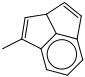

--------------------------------------------------------------
4 	 C2H4(34) 	 0.04425902 	 28


--------------------------------------------------------------
5 	 S(5714) 	 0.04163676 	 128


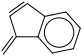

--------------------------------------------------------------
6 	 C2H2(2) 	 0.03271985 	 26


--------------------------------------------------------------
7 	 S(12974) 	 0.00958206 	 66


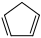

--------------------------------------------------------------
8 	 C3H6(8424) 	 0.002972078 	 42


--------------------------------------------------------------
9 	 C#CC(7679) 	 0.002838743 	 40


--------------------------------------------------------------


In [7]:
########## User Input ####################
dominant_list = [0, 9] 
##########################################


# sort out the moleFraction_dict in the descending order
v = list(moleFraction_dict.values())
k = list(moleFraction_dict.keys())
index_list = [i[0] for i in sorted(enumerate(v), key=lambda x:x[1], reverse=True)]
print '=============================================================='
print 'Order \t Species \t Mole Frac. \t MW (g/mol)'
print '=============================================================='

for order in range(dominant_list[0], dominant_list[-1]+1):
    index_number = index_list[order]
    species_dominant = k[index_number]
    molecule_dominant = species_identifier_dict.get(species_dominant)
    mole_fraction = v[index_number]
    molecular_weight = molecule_dominant.molecule[0].getMolecularWeight()*1000
    if len(species_dominant) < 6: # if the species label is too short, put more space to allign it
        print '{0} \t {1} \t\t {2} \t {3:.0f}'.format(order, species_dominant, mole_fraction, molecular_weight)
    else:
        print '{0} \t {1} \t {2} \t {3:.0f}'.format(order, species_dominant, mole_fraction, molecular_weight)
    display(molecule_dominant)
    print '--------------------------------------------------------------'

## [user input] Functionality 2: find paths between two species

Pleae specify

- source species

- target species

In [8]:
########## User Input ####################
src_species = 'C10H12(1)'
tgt_species = 'C(8044)'
##########################################

## output1: sort out all the paths and most significant one

In [9]:
paths = list(nx.all_simple_paths(G, source=src_species, target=tgt_species, cutoff=5))

In [10]:
path_fluxes = []
if showIntegratedFlux:
    print '========================================================================================================'
    print 'Path index \t Integrated Flux (mole)    Path steps'
else:
    print '================================================'
    print 'Path index \t Flux (mole/cm3/s)    Path steps'
print ''

for i, path in enumerate(paths):
    
    path_steps = len(path) - 1
    fluxes = [G[path[step]][path[step+1]]['total_flux'] for step in range(path_steps) ]
    path_fluxes.append(min(fluxes))
    if showIntegratedFlux:
        print 'Path #{0}: \t {1:.3E} \t\t  {2}'.format(i, min(fluxes), path)
    else:
        print 'Path #{0}: \t {1:.3E} \t {2}'.format(i, min(fluxes), path)
sorted_path_fluxes = sorted(path_fluxes)

print ''
print '======================================================='
print '\t Most Significant Path '
print '======================================================='
if showIntegratedFlux:
    print 'Path index \t Integrated Flux (mole)'
    print 'Path #{0}: \t {1:.3E}'.format(path_fluxes.index(sorted_path_fluxes[-1]), sorted_path_fluxes[-1])
else:
    print 'Path index \t Flux (mole/cm3/s)'
    print 'Path #{0}: \t {1:.3E} '.format(path_fluxes.index(sorted_path_fluxes[-1]), sorted_path_fluxes[-1])

Path index 	 Integrated Flux (mole)    Path steps

Path #0: 	 0.000E+00 		  ['C10H12(1)', 'H(5)', 'C3H5(1795)', 'C3H5(8050)', 'CH3(3)', 'C(8044)']
Path #1: 	 0.000E+00 		  ['C10H12(1)', 'H(5)', 'C3H5(1795)', 'C3H6(8424)', 'CH3(3)', 'C(8044)']
Path #2: 	 0.000E+00 		  ['C10H12(1)', 'H(5)', 'C4H7(501)', 'C4H8(8817)', 'CH3(3)', 'C(8044)']
Path #3: 	 0.000E+00 		  ['C10H12(1)', 'H(5)', 'S(5325)', 'C3H5(8050)', 'CH3(3)', 'C(8044)']
Path #4: 	 0.000E+00 		  ['C10H12(1)', 'H(5)', 'CH3(3)', 'C(8044)']
Path #5: 	 0.000E+00 		  ['C10H12(1)', 'H(5)', 'C2H5(4)', 'CH3(3)', 'C(8044)']
Path #6: 	 0.000E+00 		  ['C10H12(1)', 'H(5)', 'C3H5(8050)', 'CH3(3)', 'C(8044)']
Path #7: 	 0.000E+00 		  ['C10H12(1)', 'H(5)', 'S(18377)', 'C3H6(8424)', 'CH3(3)', 'C(8044)']
Path #8: 	 0.000E+00 		  ['C10H12(1)', 'S(105)', 'S(121)', 'H(5)', 'CH3(3)', 'C(8044)']
Path #9: 	 0.000E+00 		  ['C10H12(1)', 'S(105)', 'S(104)', 'H(5)', 'CH3(3)', 'C(8044)']
Path #10: 	 0.000E+00 		  ['C10H12(1)', 'S(104)', 'H(5)', 'CH3(3)', 'C

### [user input] output2: visualize the path of interest

Please specify

- the path index you want to visualize


	 Pathway Report 
The pathway you are intested in has 6 steps.

Step1 				 Integrated Flux (mole)
***********************************************************************
C10H12(1) --> S(104) 		 4.288E-05
***********************************************************************

Example H_Abstraction: rxn#15 (1/5 H_Abs): 

C2H3(33) + tetralin(1) <=> C2H4(34) + [CH]1CCc2ccccc2C1(104)


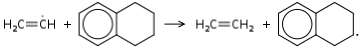

Forward rate coefficient at 1200 K: 1.15E+05 [cm3, mole, s]
Reverse rate coefficient at 1200 K: 6.74E+02 [cm3, mole, s]


Step2 				 Integrated Flux (mole)
***********************************************************************
S(104) --> H(5) 		 1.237E-05
***********************************************************************

Example reaction: rxn#82

H(5) + C1=Cc2ccccc2CC1(120) <=> [CH]1CCc2ccccc2C1(104)


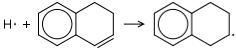

Forward rate coefficient at 1200 K: 3.96E+06 [cm3, mole, s]
Reverse rate coefficient at 1200 K: 1.94E+07 [cm3, mole, s]

Example reaction: rxn#30

H(5) + pdt38(77) <=> [CH]1CCc2ccccc2C1(104)


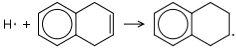

Forward rate coefficient at 1200 K: 1.84E+07 [cm3, mole, s]
Reverse rate coefficient at 1200 K: 1.41E+08 [cm3, mole, s]


Step3 				 Integrated Flux (mole)
***********************************************************************
H(5) --> C3H5(8050) 		 2.337E-05
***********************************************************************

Example reaction: rxn#1619

C#CC(7679) + H(5) <=> [CH]=CC(8050)


Forward rate coefficient at 1200 K: 7.23E+06 [cm3, mole, s]
Reverse rate coefficient at 1200 K: 1.24E+07 [cm3, mole, s]


Step4 				 Integrated Flux (mole)
***********************************************************************
C3H5(8050) --> CH3(3) 		 4.050E-05
***********************************************************************

Example reaction: rxn#498

CH3(3) + C2H2(2) <=> [CH]=CC(8050)


Forward rate coefficient at 1200 K: 2.06E+05 [cm3, mole, s]
Reverse rate coefficient at 1200 K: 2.70E+08 [cm3, mole, s]


Step5 				 Integrated Flux (mole)
***********************************************************************
CH3(3) --> C(8044) 		 6.808E-05
***********************************************************************

Example H_Abstraction: rxn#503 (1/10 H_Abs): 

C(8044) + [c]1cccc2CCCCc12(106) <=> CH3(3) + tetralin(1)


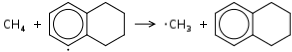

Forward rate coefficient at 1200 K: 5.43E+04 [cm3, mole, s]
Reverse rate coefficient at 1200 K: 1.04E+03 [cm3, mole, s]



In [11]:
########## User Input ####################
path_index_investigate = 12
##########################################

path = paths[path_index_investigate]
path_steps = len(path) - 1
print ''
print '\t Pathway Report '
print '======================================'
print 'The pathway you are intested in has {0} steps.'.format(len(path))
for step in range(path_steps):
    step_pair = (path[step], path[step+1])
    h_abs_rxns = []
    disp_rxns = []
    Pdep_rxns = []
    
    print ""
    if showIntegratedFlux:
        print "Step{0} \t\t\t\t Integrated Flux (mole)".format(step+1)
        print '***********************************************************************'
        print "{1} --> {2} \t\t {3:.3E}".\
        format(step+1, step_pair[0], step_pair[1], G[step_pair[0]][step_pair[1]]['total_flux'])
        print '***********************************************************************'
    else:
        print "Step{0} \t\t\t\t Flux (mole/cm3/s)".format(step+1)
        print '*****************************************************'
        print "{1} --> {2} \t\t {3:.3E}".\
        format(step+1, step_pair[0], step_pair[1], G[step_pair[0]][step_pair[1]]['total_flux'])
        print '*****************************************************'
    
    if step_pair not in graph_edges_dict_simple:
        step_pair = (step_pair[1], step_pair[0])
    
    print ''
    for rxn in graph_edges_dict_simple[step_pair]:
        if isinstance(rxn, PDepReaction):
            Pdep_rxns.append(rxn)
        elif rxn.family == "H_Abstraction":
            h_abs_rxns.append(rxn)
        elif rxn.family == "Disproportionation":
            disp_rxns.append(rxn)
        else:
            print "Example reaction: rxn#{0}".format(rxn.index)
            print ''
            print str(rxn)
            display(rxn)
            print 'Forward rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, rxn.getRateCoefficient(T))
            reverseRate = rxn.generateReverseRateCoefficient()
            print 'Reverse rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, reverseRate.getRateCoefficient(T))
            print ''
    if len(h_abs_rxns) > 0: 
        
        print "Example H_Abstraction: rxn#{0} (1/{1} H_Abs): ".format(h_abs_rxns[0].index, len(h_abs_rxns)) 
        print ''
        print str(h_abs_rxns[0])
        display(h_abs_rxns[0])
        print 'Forward rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, h_abs_rxns[0].getRateCoefficient(T))
        reverseRate = h_abs_rxns[0].generateReverseRateCoefficient()
        print 'Reverse rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, reverseRate.getRateCoefficient(T))
        print ''
    if len(disp_rxns) > 0: 
        
        print "Example Disproportionation: rxn#{0} (1/{1} Disp): ".format(disp_rxns[0].index, len(disp_rxns)) 
        print ''
        print str(disp_rxns[0])
        display(disp_rxns[0])
        print 'Forward rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, disp_rxns[0].getRateCoefficient(T))
        reverseRate = disp_rxns[0].generateReverseRateCoefficient()
        print 'Reverse rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, reverseRate.getRateCoefficient(T))
        print ''
    if len(Pdep_rxns) > 0: 
        
        print "Example Pressure-dependent Rxn: rxn#{0} (1/{1} Pdep_rxns): ".format(Pdep_rxns[0].index, len(Pdep_rxns)) 
        print ''
        print str(Pdep_rxns[0])
        display(Pdep_rxns[0])
        print 'Forward rate coefficient at {0} K and {1} Pa: {2:.2E} [cm3, mole, s]'.format(T, P, Pdep_rxns[0].getRateCoefficient(T, P))
        reverseRate = Pdep_rxns[0].generateReverseRateCoefficient()
        print 'Reverse rate coefficient at {0} K and {1} Pa: {2:.2E} [cm3, mole, s]'.format(T, P, reverseRate.getRateCoefficient(T, P))
        print ''

## [user input] Functionality 3: find paths from a particular species

Please specify

- source species

- depth of pathway you want search, e.g., depth = 2 means search pathways 2 steps down from source species

- path_top_list, e.g., [0, 3] means 1st step of the pathway takes the most significant branch and 2nd step would be the third most siginificant branch


	 Pathway Report 
The pathway you are intested in has 2 steps.



Step1 				 Integrated Flux (mole)
************************************************************************
S(16320) --> S(16189) 		 2.820E-07
************************************************************************

Example reaction: rxn#721

C1=CC=C2C(C=Cc3ccccc32)=C1(16320) + H(5) <=> [CH]1C=C2C=CC=CC2=C2C=CC=CC12(16189): Integrated Flux = -2.820E-07 mole


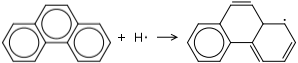

Forward rate coefficient at 1200 K: 9.72E+05 [cm3, mole, s]
Reverse rate coefficient at 1200 K: 2.30E+12 [cm3, mole, s]


Example Disproportionation: rxn#725(1/4 Disp)

C1=CC2=CC[C]1c1ccccc12(194) + [CH]1C=C2C=CC=CC2=C2C=CC=CC12(16189) <=> C1=CC=C2C(C=Cc3ccccc32)=C1(16320) + C1C=C2CCC=1c1ccccc12(193)


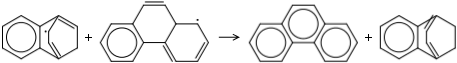

Forward rate coefficient at 1200 K: 1.93E+06 [cm3, mole, s]
Reverse rate coefficient at 1200 K: 7.32E-07 [cm3, mole, s]




Step2 				 Integrated Flux (mole)
************************************************************************
S(16189) --> S(16310) 		 5.649E-07
************************************************************************

Example reaction: rxn#1323

[CH]=Cc1ccccc1C1C=CC=CC=1(16310) <=> [CH]1C=C2C=CC=CC2=C2C=CC=CC12(16189): Integrated Flux = 5.649E-07 mole


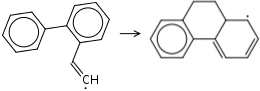

Forward rate coefficient at 1200 K: 1.09E+08 [cm3, mole, s]
Reverse rate coefficient at 1200 K: 1.39E+10 [cm3, mole, s]



In [20]:
########## User Input ####################
source = "S(16320)"
depth = 2
path_top_list = [0, 0]
##########################################


current_node = source

print ''
print '\t Pathway Report '
print '======================================'
print 'The pathway you are intested in has {0} steps.'.format(depth)
for step in range(depth):
    print "\n"    
    nextNode_flux_list = [(next_node, G[current_node][next_node]['total_flux']) for next_node in G[current_node]]
    sorted_nextNode_flux_list = sorted(nextNode_flux_list, key=lambda tup: -tup[1])
    
    # choose the top one as next node
    tup = sorted_nextNode_flux_list[path_top_list[step]]
    next_node = tup[0]
    step_flux = tup[1]
    
    print ""
    if showIntegratedFlux:
        print "Step{0} \t\t\t\t Integrated Flux (mole)".format(step+1)
        print '************************************************************************'
        print "{0} --> {1} \t\t {2:.3E}".\
        format(current_node, next_node, step_flux)
        print '************************************************************************'
    else:
        print "Step{0} \t\t\t\t Flux (mole/cm3/s)".format(step+1)
        print '****************************************************'
        print "{0} --> {1} \t\t {2:.3E}".\
        format(current_node, next_node, step_flux)
        print '****************************************************'

    
    step_pair = (current_node, next_node)
    if step_pair not in graph_edges_dict_simple:
        step_pair = (next_node, current_node)
    
    h_abs_rxns = []
    disp_rxns = []
    Pdep_rxns = []
    for rxn in graph_edges_dict_simple[step_pair]:
        if isinstance(rxn, PDepReaction):
            Pdep_rxns.append(rxn)
        elif rxn.family == "H_Abstraction":
            h_abs_rxns.append(rxn)
        elif rxn.family == "Disproportionation":
            disp_rxns.append(rxn)
        else:
            print ''
            print "Example reaction: rxn#{0}".format(rxn.index)
            print ''
            if showIntegratedFlux:
            #integrate the flux using a trapezoidal rule
                integrated_flux = 0
                for t in range(timepoint_index):
                    rxnROP0 = graph_edges_dict_simple[step_pair][rxn][t]
                    rxnROP1 = graph_edges_dict_simple[step_pair][rxn][t+1]
                    integrated_flux += 0.5 * (rxnROP1 * Vlist[t+1] + rxnROP0 * Vlist[t]) * (timeList[t+1] - timeList[t]) # in mole
                print "{0}: Integrated Flux = {1:.3E} mole".format(str(rxn), integrated_flux)
            else:
                print "{0}: Flux = {1:.3E} mole/cm3/s".format(str(rxn), graph_edges_dict_simple[step_pair][rxn][timepoint_index])
            display(rxn)
            print 'Forward rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, rxn.getRateCoefficient(T))
            reverseRate = rxn.generateReverseRateCoefficient()
            print 'Reverse rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, reverseRate.getRateCoefficient(T))
            print ''
    if len(h_abs_rxns) > 0:
        print ''
        print "Example H_Abstraction: rxn#{0}(1/{1} H_Abs)".format(h_abs_rxns[0].index, len(h_abs_rxns))
        print ''
        print str(h_abs_rxns[0])
        display(h_abs_rxns[0])
        print 'Forward rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, h_abs_rxns[0].getRateCoefficient(T))
        reverseRate = h_abs_rxns[0].generateReverseRateCoefficient()
        print 'Reverse rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, reverseRate.getRateCoefficient(T))
        print ''
    if len(disp_rxns) > 0: 
        print ''
        print "Example Disproportionation: rxn#{0}(1/{1} Disp)".format(disp_rxns[0].index, len(disp_rxns))
        print ''
        print str(disp_rxns[0])
        display(disp_rxns[0])
        print 'Forward rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, disp_rxns[0].getRateCoefficient(T))
        reverseRate = disp_rxns[0].generateReverseRateCoefficient()
        print 'Reverse rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, reverseRate.getRateCoefficient(T))
        print ''
    if len(Pdep_rxns) > 0: 
        print ''
        print "Example Pressure-dependent Rxn: rxn#{0} (1/{1} Pdep_rxns): ".format(Pdep_rxns[0].index, len(Pdep_rxns)) 
        print ''
        print str(Pdep_rxns[0])
        display(Pdep_rxns[0])
        print 'Forward rate coefficient at {0} K and {1} Pa: {2:.2E} [cm3, mole, s]'.format(T, P, Pdep_rxns[0].getRateCoefficient(T, P))
        reverseRate = Pdep_rxns[0].generateReverseRateCoefficient()
        print 'Reverse rate coefficient at {0} K and {1} Pa: {2:.2E} [cm3, mole, s]'.format(T, P, reverseRate.getRateCoefficient(T, P))
        print ''
    
    current_node = next_node

### More detail for the H_Abstration and Disproportionation in last step of the pathway

In [ ]:
print ''
print 'The step you see currently is between the two species {0}'.format(step_pair)
print ''
print 'Positive flux in below means positive production of 1st node of the pair.'
print ''
print 'This step have {0} H_Abstration and Disproportionation in total.'.format(len(h_abs_rxns + disp_rxns))

flux_threshold = 1e-9

print ''
print 'TO avoid too much printout, the reactions shown below have fluxes above {0}.'.format(flux_threshold)

total_flux = 0
rxn_flux_tups = []
for rxn in h_abs_rxns + disp_rxns:
    if showIntegratedFlux:
    #integrate the flux using a trapezoidal rule
        flux = 0
        for t in range(timepoint_index):
            rxnROP0 = graph_edges_dict_simple[step_pair][rxn][t]
            rxnROP1 = graph_edges_dict_simple[step_pair][rxn][t+1]
            flux += 0.5 * (rxnROP1 * Vlist[t+1] + rxnROP0 * Vlist[t]) * (timeList[t+1] - timeList[t]) # in mole
    else:
        flux = graph_edges_dict_simple[step_pair][rxn][timepoint_index]
    rxn_flux_tups.append((rxn, flux))
    

rxn_flux_tups = sorted(rxn_flux_tups, key=lambda tup: tup[1], reverse=False)
for tup in rxn_flux_tups:
    rxn = tup[0]
    flux = tup[1]
    if flux > flux_threshold:
        total_flux += flux
        print ''
        print "**********************************************************************************"
        if showIntegratedFlux:
            print "rxn#{0}: {1}: Integrated Flux = {2:.3E} mole ".format(rxn.index, str(rxn), flux) 
        else:
            print "rxn#{0}: {1}: Flux = {2:.3E} mole/cm3/s".format(rxn.index, str(rxn), flux)
        display(rxn) 
print "***************************************"
print ''
if showIntegratedFlux:
    print "TOTAL integrated flux from h_abs and disp is {0:.3E} mole.".format(total_flux)
else:
    print "TOTAL flux from h_abs and disp is {0:.3E} mole/cm3/s.".format(total_flux)

## [user input] Functionality 4: find paths towards a particular species

Similar to functionality 2, please specify

Please specify

- target species

- depth of pathway you want search, e.g., depth = 2 means search pathways 2 steps up beyond target species

- path_top_list, e.g., [0, 3] means 1st step of the pathway takes the most significant branch and 2nd step would be the third most siginificant branch


	 Pathway Report 
The pathway you are intested in has 2 steps.

total integrated product flux for S(16320) is 2.975E-05 mole.



Step1 				 Integrated Flux (mole)
************************************************************************
S(16320) <-- C12H9(808) 		 2.345E-05
************************************************************************

Example reaction: rxn#1379

C1=CC=C2C(C=Cc3ccccc32)=C1(16320) + H(5) <=> [CH]1CC2C=CC=CC=2C2C=CC=CC=21(16463): Integrated Flux = -2.345E-05 mole


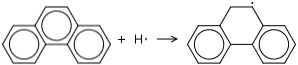

Forward rate coefficient at 1200 K: 1.50E+06 [cm3, mole, s]
Reverse rate coefficient at 1200 K: 2.28E+09 [cm3, mole, s]

Example Disproportionation: rxn#1394(1/3 Disp)

[CH]1CC2C=CC=CC=2C2C=CC=CC=21(16463) + CC1C2=CC=C3C=CC4[C]3C2C=CC=41(12339) <=> CC1C2=CC=C3C=CC4=C1C=CC2C34(12608) + C1=CC=C2C(C=Cc3ccccc32)=C1(16320)


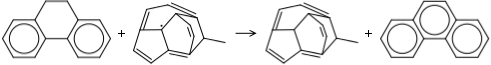

Forward rate coefficient at 1200 K: 2.12E+06 [cm3, mole, s]
Reverse rate coefficient at 1200 K: 8.91E-07 [cm3, mole, s]




Step2 				 Integrated Flux (mole)
************************************************************************
S(16463) <-- C12H9(808) 		 2.290E-05
************************************************************************

Example reaction: rxn#1400

C=Cc1ccccc1-c1[c]cccc1(23301) <=> [CH]1CC2C=CC=CC=2C2C=CC=CC=21(16463): Integrated Flux = -2.290E-05 mole


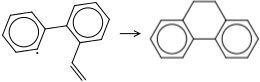

Forward rate coefficient at 1200 K: 2.86E+10 [cm3, mole, s]
Reverse rate coefficient at 1200 K: 9.55E+08 [cm3, mole, s]


In [28]:
########## User Input ####################
target = "S(16320)"
depth = 2
path_top_list = [0, 0]
##########################################


current_node = target
print ''
print '\t Pathway Report '
print '======================================'
print 'The pathway you are intested in has {0} steps.'.format(depth)
print ''
if showIntegratedFlux:
    product_flux = 0
    for t in range(timepoint_index):
        productROP0 = spc_total_rop_dict[target][1][t]
        productROP1 = spc_total_rop_dict[target][1][t+1]
        product_flux += 0.5 * (productROP1 * Vlist[t+1] + productROP0 * Vlist[t]) * (timeList[t+1] - timeList[t]) # in mole
    print "total integrated product flux for {0} is {1:.3E} mole.".format(target, product_flux)
else:
    print "total product flux for {0} is {1:.3E} mole/cm3/s.".format(target, spc_total_rop_dict[target][1][timepoint_index])
for step in range(depth):
    print "\n"
    prev_nodes = []
    for node1 in G:
        if current_node in G[node1]:
            prev_nodes.append(node1)
    prevNode_flux_list = [(prev_node, G[prev_node][current_node]['total_flux']) for prev_node in prev_nodes]
    sorted_prevNode_flux_list = sorted(prevNode_flux_list, key=lambda tup: -tup[1])
    
    # choose the top one as next node
    tup = sorted_prevNode_flux_list[path_top_list[step]]
    prev_node = tup[0]
    step_flux = tup[1]
    
    print ""
    if showIntegratedFlux:
        print "Step{0} \t\t\t\t Integrated Flux (mole)".format(step+1)
        print '************************************************************************'
        print "{0} <-- {1} \t\t {2:.3E}".\
        format(current_node, next_node, step_flux)
        print '************************************************************************'
    else:
        print "Step{0} \t\t\t\t Flux (mole/cm3/s)".format(step+1)
        print '****************************************************'
        print "{0} <-- {1} \t\t {2:.3E}".\
        format(current_node, next_node, step_flux)
        print '****************************************************'
    
    step_pair = (prev_node, current_node)
    if step_pair not in graph_edges_dict_simple:
        step_pair = (current_node, prev_node)
    
    h_abs_rxns = []
    disp_rxns = []
    Pdep_rxns = []
    for rxn in graph_edges_dict_simple[step_pair]:
        if isinstance(rxn, PDepReaction):
            Pdep_rxns.append(rxn)
        elif rxn.family == "H_Abstraction":
            h_abs_rxns.append(rxn)
        elif rxn.family == "Disproportionation":
            disp_rxns.append(rxn)
        else:
            print ''
            print "Example reaction: rxn#{0}".format(rxn.index)
            print ''
            if showIntegratedFlux:
            #integrate the flux using a trapezoidal rule
                integrated_flux = 0
                for t in range(timepoint_index):
                    rxnROP0 = graph_edges_dict_simple[step_pair][rxn][t]
                    rxnROP1 = graph_edges_dict_simple[step_pair][rxn][t+1]
                    integrated_flux += 0.5 * (rxnROP1 * Vlist[t+1] + rxnROP0 * Vlist[t]) * (timeList[t+1] - timeList[t]) # in mole
                print "{0}: Integrated Flux = {1:.3E} mole".format(str(rxn), integrated_flux)
            else:
                print "{0}: Flux = {1:.3E} mole/cm3/s".format(str(rxn), graph_edges_dict_simple[step_pair][rxn][timepoint_index])
            display(rxn)
            print 'Forward rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, rxn.getRateCoefficient(T))
            reverseRate = rxn.generateReverseRateCoefficient()
            print 'Reverse rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, reverseRate.getRateCoefficient(T))
            
    if len(h_abs_rxns) > 0:
        print ''
        print "Example H_Abstraction: rxn#{0}(1/{1} H_Abs)".format(h_abs_rxns[0].index, len(h_abs_rxns))
        print ''
        print str(h_abs_rxns[0])
        display(h_abs_rxns[0])
        print 'Forward rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, h_abs_rxns[0].getRateCoefficient(T))
        reverseRate = h_abs_rxns[0].generateReverseRateCoefficient()
        print 'Reverse rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, reverseRate.getRateCoefficient(T))
        print ''
    if len(disp_rxns) > 0: 
        print ''
        print "Example Disproportionation: rxn#{0}(1/{1} Disp)".format(disp_rxns[0].index, len(disp_rxns))
        print ''
        print str(disp_rxns[0])
        display(disp_rxns[0])
        print 'Forward rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, disp_rxns[0].getRateCoefficient(T))
        reverseRate = disp_rxns[0].generateReverseRateCoefficient()
        print 'Reverse rate coefficient at {0} K: {1:.2E} [cm3, mole, s]'.format(T, reverseRate.getRateCoefficient(T))
        print ''
    if len(Pdep_rxns) > 0: 
        print ''
        print "Example Pressure-dependent Rxn: rxn#{0} (1/{1} Pdep_rxns): ".format(Pdep_rxns[0].index, len(Pdep_rxns)) 
        print ''
        print str(Pdep_rxns[0])
        display(Pdep_rxns[0])
        print 'Forward rate coefficient at {0} K and {1} Pa: {2:.2E} [cm3, mole, s]'.format(T, P, Pdep_rxns[0].getRateCoefficient(T, P))
        reverseRate = Pdep_rxns[0].generateReverseRateCoefficient()
        print 'Reverse rate coefficient at {0} K and {1} Pa: {2:.2E} [cm3, mole, s]'.format(T, P, reverseRate.getRateCoefficient(T, P))
        print ''
    
    current_node = prev_node

### More detail for the H_Abstration and Disproportionation in last step of the pathway

In [ ]:
print ''
print 'The step you see currently is between the two species {0}'.format(step_pair)
print ''
print 'Positive flux in below means positive production of 1st node of the pair.'
print ''
print 'This step have {0} H_Abstration and Disproportionation in total.'.format(len(h_abs_rxns + disp_rxns))

flux_threshold = 1e-9

print ''
print 'TO avoid too much printout, the reactions shown below have fluxes above {0}.'.format(flux_threshold)

total_flux = 0
rxn_flux_tups = []
for rxn in h_abs_rxns + disp_rxns:
    if showIntegratedFlux:
    #integrate the flux using a trapezoidal rule
        flux = 0
        for t in range(timepoint_index):
            rxnROP0 = graph_edges_dict_simple[step_pair][rxn][t]
            rxnROP1 = graph_edges_dict_simple[step_pair][rxn][t+1]
            flux += 0.5 * (rxnROP1 * Vlist[t+1] + rxnROP0 * Vlist[t]) * (timeList[t+1] - timeList[t]) # in mole
    else:
        flux = graph_edges_dict_simple[step_pair][rxn][timepoint_index]
    rxn_flux_tups.append((rxn, flux))

rxn_flux_tups = sorted(rxn_flux_tups, key=lambda tup: tup[1], reverse=False)
for tup in rxn_flux_tups:
    rxn = tup[0]
    flux = tup[1]
    if flux > flux_threshold:
        total_flux += flux
        print ''
        print "**********************************************************************************"
        if showIntegratedFlux:
            print "rxn#{0}: {1}: Integrated Flux = {2:.3E} mole ".format(rxn.index, str(rxn), flux) 
        else:
            print "rxn#{0}: {1}: Flux = {2:.3E} mole/cm3/s".format(rxn.index, str(rxn), flux)
        display(rxn) 
print "***************************************"
print ''
if showIntegratedFlux:
    print "TOTAL integrated flux from h_abs and disp is {0:.3E} mole.".format(total_flux)
else:
    print "TOTAL flux from h_abs and disp is {0:.3E} mole/cm3/s.".format(total_flux)
